# Feature generation

## Feature generated

In this notebook we will try generate the following features based on the dataset : 

cumulated depth : somme des volumes disponibles jusqu’à un certain niveau
(p. ex. top 10) de chaque côté

imbalance of the book-order : (V_bid - V_ask)/(V_bid + V_ask)

Écart acheteur-vendeur (Spread) :
prix_ask_min – prix_bid_max

liquidity ratio : V_bid/V_ask

Statistical temporal features: Instantaneous volatility (variance over short windows), momentum (change in mid-price, trend indicators), and volume indicators (VWAP, average volume).

Other : book slope (slope of the volume-price curve), implied volatility indicators, etc.



Cannot be done with the current data :

Order Flow : somme entre volume total
d’ordres acheteurs et vendeurs exécutés (ou modifiés) sur une fenêtre

Order Flow Imbalance : différence entre volume total
d’ordres acheteurs et vendeurs exécutés (ou modifiés) sur une fenêtre

Multi-line order flow : Extension of OFI, measuring the net flow at the top N levels


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('../data/processed/cleaned_data_btc.csv')

features = pd.DataFrame(index=df.index)

## Generating bid-ask-imbalance or cumulative depth

Close to 1 → strong buying pressure.
Close to -1 → strong selling pressure.
Near 0 → balanced depth.


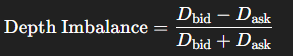


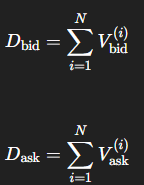

In [ ]:
N_level = 5

features[f"V-bid-{N_level}-levels"] = df["level-1-bid-volume"]
features[f"V-ask-{N_level}-levels"] = df["level-1-ask-volume"]

for i in range(2, N_level + 1):
    features[f"V-bid-{N_level}-levels"] += df[f"level-{i}-bid-volume"]
    features[f"V-ask-{N_level}-levels"] += df[f"level-{i}-ask-volume"]

features[f"bid-ask-imbalance-{N_level}-levels"] = (features[f"V-bid-{N_level}-levels"] - features[f"V-ask-{N_level}-levels"])/(features[f"V-bid-{N_level}-levels"] + features[f"V-ask-{N_level}-levels"])


## Generating spread

In [ ]:
features["spread"] = df["level-1-ask-price"] - df["level-1-bid-price"]

## Generating book slope

Used to estimate the steepness of liquidity
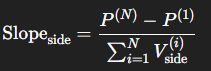

In [ ]:
N_level = 5

for side in ['bid', 'ask']:
    price_col = [f"level-{i}-{side}-price" for i in range(1, N_level + 1)]
    volume_col = [f"level-{i}-{side}-volume" for i in range(1, N_level + 1)]
    P_N = df[price_col[-1]]
    P_1 = df[price_col[0]]
    V_sum = sum([df[col] for col in volume_col])
    features[f"slope-{side}-{N_level}-levels"] = (P_N - P_1) / V_sum


## Generating Volume-Weighted Average Price Depth (VWAP Depth)

This gives a weighted price level that reflects available liquidity
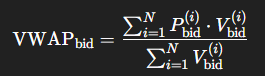

In [ ]:
# Calculate VWAP for bid and ask sides over N_level depth
N_level = 5

# Bid side VWAP
bid_price_cols = [f"level-{i}-bid-price" for i in range(1, N_level + 1)]
bid_volume_cols = [f"level-{i}-bid-volume" for i in range(1, N_level + 1)]
bid_prices = df[bid_price_cols]
bid_volumes = df[bid_volume_cols]
vwap_bid = (bid_prices * bid_volumes).sum(axis=1) / bid_volumes.sum(axis=1)
features[f"vwap-bid-{N_level}-levels"] = vwap_bid

# Ask side VWAP
ask_price_cols = [f"level-{i}-ask-price" for i in range(1, N_level + 1)]
ask_volume_cols = [f"level-{i}-ask-volume" for i in range(1, N_level + 1)]
ask_prices = df[ask_price_cols]
ask_volumes = df[ask_volume_cols]
vwap_ask = (ask_prices * ask_volumes).sum(axis=1) / ask_volumes.sum(axis=1)
features[f"vwap-ask-{N_level}-levels"] = vwap_ask

## Generating Liquidity Ratio

liquidity ratio : V_bid/V_ask

In [ ]:
N_level = 5

features["liquidity-ratio"] = features[f"V-bid-{N_level}-levels"] / features[f"V-ask-{N_level}-levels"]

## Generating Instantaneous volatility (variance over short windows), momentum (change in mid-price, trend indicators), and volume indicators (VWAP, average volume)

Note : average is done in terms over the last transactions, and not over a  

In [ ]:
window = 20  # You can adjust the window size as needed

# Mid-price calculation
mid_price = (df["level-1-bid-price"] + df["level-1-ask-price"]) / 2

# Instantaneous volatility (rolling variance of mid-price)
features["inst_volatility"] = mid_price.rolling(window=window).var()

# Momentum (change in mid-price)
features["momentum"] = mid_price.diff(periods=window)

# Trend indicator (rolling mean of mid-price)
features["mid_price_trend"] = mid_price.rolling(window=window).mean()

# VWAP over all levels (already computed for N_level=5, but can do for all if needed)
# Here, we use the previously computed vwap_bid and vwap_ask for N_level=5
N_level=5
features["vwap_mid"] = (features[f"vwap-bid-{N_level}-levels"] + features[f"vwap-ask-{N_level}-levels"]) / 2

# Average volume over short window (using level-1 volumes as example)
features["avg-bid-volume-level-1"] = df["level-1-bid-volume"].rolling(window=window).mean()
features["avg-ask-volume-level-1"] = df["level-1-ask-volume"].rolling(window=window).mean()